<a href="https://colab.research.google.com/github/KalusaniLaxman/nlp_lab/blob/main/NLP_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


LogisticRegression {'model': LogisticRegression(max_iter=2000, random_state=42, solver='liblinear'), 'accuracy': 0.8671943711521548, 'precision': 0.8457142857142858, 'recall': 0.34988179669030733, 'f1': 0.49498327759197325}
              precision    recall  f1-score   support

           0       0.87      0.99      0.92      1851
           1       0.85      0.35      0.49       423

    accuracy                           0.87      2274
   macro avg       0.86      0.67      0.71      2274
weighted avg       0.86      0.87      0.84      2274

RandomForest {'model': RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42), 'accuracy': 0.8808267370272648, 'precision': 0.7878787878787878, 'recall': 0.491725768321513, 'f1': 0.6055312954876274}
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1851
           1       0.79      0.49      0.61       423

    accuracy                           0.88      2274
   macro avg      

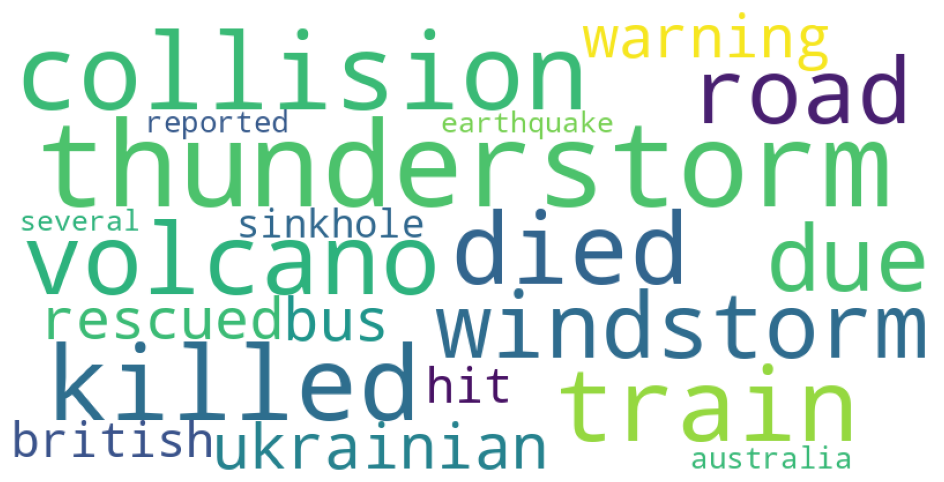

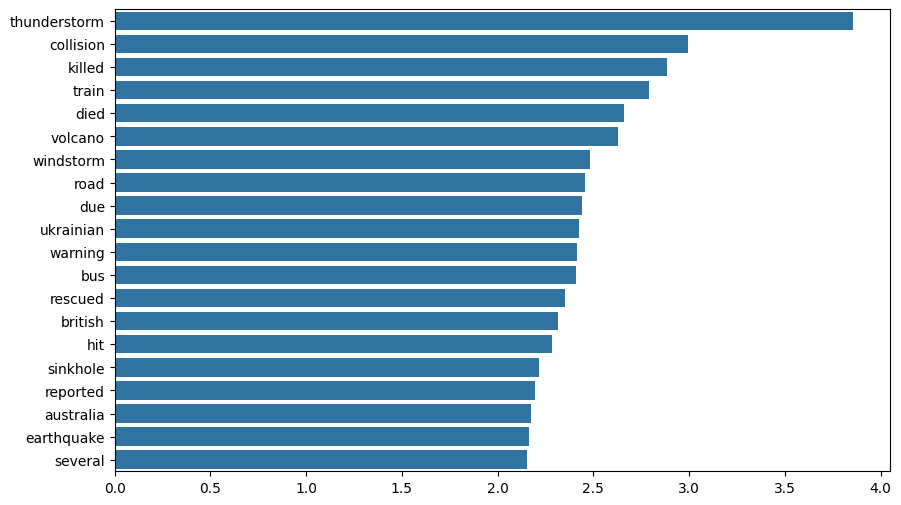

In [3]:
import os,re,numpy as np,pandas as pd,matplotlib.pyplot as plt,seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Set NLTK data path to a temporary directory
nltk.data.path.append('/tmp/nltk_data')

for pkg in ["punkt","stopwords","averaged_perceptron_tagger","punkt_tab"]:
    try:nltk.data.find(f'tokenizers/{pkg}')
    except LookupError:nltk.download(pkg)
STOPWORDS=set(stopwords.words("english"))

def clean_text(t):
    if pd.isna(t):return ""
    t=str(t).lower()
    t=re.sub(r'http\S+|www\.\S+',' ',t)
    t=re.sub(r'@\w+',' ',t)
    t=t.replace('#',' ')
    t=re.sub(r'[^a-z\s]',' ',t)
    return re.sub(r'\s+',' ',t).strip()
def tok_stop(t):
    return " ".join([w for w in word_tokenize(t) if w not in STOPWORDS and len(w)>1])

df=pd.read_csv("/content/archive (5).zip")
df['clean']=df['text'].astype(str).map(clean_text).map(tok_stop)
X=df['clean'].values;y=df['target'].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
tfidf=TfidfVectorizer(ngram_range=(1,2),min_df=5,max_df=0.9,max_features=20000)
X_train_t=tfidf.fit_transform(X_train);X_test_t=tfidf.transform(X_test)
fns=np.array(tfidf.get_feature_names_out())
models={"LogisticRegression":LogisticRegression(max_iter=2000,solver='liblinear',C=1.0,random_state=42),
        "RandomForest":RandomForestClassifier(n_estimators=200,random_state=42,n_jobs=-1),
        "DecisionTree":DecisionTreeClassifier(random_state=42)}
res={}
for n,m in models.items():
    m.fit(X_train_t,y_train);p=m.predict(X_test_t)
    res[n]={"model":m,"accuracy":accuracy_score(y_test,p),
            "precision":precision_score(y_test,p,zero_division=0),
            "recall":recall_score(y_test,p,zero_division=0),
            "f1":f1_score(y_test,p,zero_division=0)}
    print(n,res[n]);print(classification_report(y_test,p,zero_division=0))

lr=res["LogisticRegression"]["model"];coefs=lr.coef_[0]
tp=np.argsort(coefs)[-20:][::-1];tn=np.argsort(coefs)[:20]
top_pos=list(zip(fns[tp],coefs[tp]));top_neg=list(zip(fns[tn],coefs[tn]))
print("Top disaster:",top_pos);print("Top non-disaster:",top_neg)

for n in ["RandomForest","DecisionTree"]:
    m=res[n]["model"];imps=m.feature_importances_;idx=np.argsort(imps)[-20:][::-1]
    print(n,list(zip(fns[idx],imps[idx])))

wc=WordCloud(width=800,height=400,background_color='white',collocations=False)
wc.generate_from_frequencies({t:abs(c) for t,c in top_pos})
plt.figure(figsize=(12,6));plt.imshow(wc);plt.axis('off');plt.show()
plt.figure(figsize=(10,6));sns.barplot(x=[c for t,c in top_pos],y=[t for t,c in top_pos]);plt.show()